# Cross-Model Comparison Notebook

In [79]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
from data.param_data_loader2 import ParamDL2, ParamDL2Chunks, cf_failure_dict
dataset = ParamDL2()

clusterer = ParamDL2Chunks(dataset, cf_failure_dict, 30, 20, data_fields=["calibratedAx", "accelpedal", "brakepedal"])
cl_model, _, _ = clusterer.fit(5)

Processing Congestion
Processed 24 Congestions
Saved Congestion File
Processing Car Following
Processed 60 cf_events
Saved Car Following File
Datast Loaded. Preview of dataset: 
   driver  trip  congestion  cf_idx  type    time  gmm_n_cluster  \
0       1    53         640     240     0  1698.8              4   
1       1    53         640     240     0  1698.9              4   
2       1    53         640     240     0  1699.0              4   
3       1    53         640     240     0  1699.1              4   
4       1    53         640     240     0  1699.2              4   

   rank_0_cluster  rank_1_cluster  rank_2_cluster  ...  timeHeadway  VL_theta  \
0               0               2               3  ...     2.294240  0.137128   
1               0               2               3  ...     2.304333  0.137128   
2               0               2               3  ...     2.278744  0.138907   
3               0               2               3  ...     2.277959  0.140121   
4       

In [81]:
# Import models, before other cells, so there is no need to rerun some tests
from param_models import *

models = [
    BatchIDM(dataset.cf_events, mode='cpu', name="IDM"), 
    BatchACC(dataset.cf_events, mode='cpu', name="ACC"), 
    BatchGipps(dataset.cf_events, mode='cpu', name="Gipps"), 
    BatchOVM(dataset.cf_events, mode='cpu', name="OVM"), 
    BatchFVDM(dataset.cf_events, mode='cpu', name="FVDM"), 
]

best_params = {
    "IDM": [ 1.00211871,  2.37290004,  3.06215215,  0.95444705, 23.66233063], 
    "ACC": [ 1.35105629,  1.30290699,  2.22532797,  1.25295256, 13.86810631,  4, 0.99 ], 
    "Gipps":[  3.48966739, -10.,           1.02,        12.48262406,   1.76587988, -9.43270933], 
    "OVM": [8.30666840e-01, 1.51769309e+01, 2.83147426, 1.22445571e+01, 3.89127702e-01], 
    "FVDM": [1.02484083e+00, 2.20361022e+01, 2.28523306e+00, 2.97026129e+01, 3.18387707e-03, 1.00000000e-03]
}

In [82]:
from sympy import S
import torch
import os
        
model_names = ["IDM", "ACC", "Gipps", "OVM", "FVDM", "GT"]
n_cluster = 5
duration = 3.0

def plot_sequences(model, sequence, dir, plot_colorblock=False, xlab="Time (s)", ylab="Distance (m)", fsize=(12,8), prefix="N_"):
    if not os.path.isdir(dir):
        os.makedirs(dir)
    sequence = sequence.cpu()  # Move tensor to CPU
    num_models, num_sequences, time_steps = sequence.size()
    
    colors = ['r', 'g', 'b', 'c', 'm', 'y']  # Define colors for the 5 sequences
    
    # fig, axes = plt.subplots(15, 10, figsize=(40, 80))  # Create a 12x5 grid of subplots
    # axes = axes.flatten()  # Flatten to easily index subplot
    
    for s in range(num_sequences):
        fig, ax = plt.subplots(1,1,figsize=fsize)
        s_mask = model.mask[0, s, :].detach().cpu()
        tsq = model.t_st[0,s,s_mask].detach().cpu().numpy()
        for b in range(num_models):
            # Plot the sequence
            seq = sequence[b, s, s_mask].numpy()
            ax.plot(tsq, seq, label=f'{model_names[b]}', color=colors[b])
            ax.set_xlabel(xlab, fontsize=22)
            ax.set_ylabel(ylab, fontsize=22)

        if plot_colorblock == True and s in cf_failure_dict.keys():
            df = dataset.cf_events[s]
            # sample
            cluster_times = [[] for _ in range(n_cluster)]
            for rg in cf_failure_dict[s]:
                s_t = rg[0]
                e_t = rg[1]
                while s_t + duration < e_t:
                    sample = df.loc[(df["time"] >= s_t) & (df["time"] < s_t+duration), clusterer.data_fields].to_numpy().reshape(1,-1, len(clusterer.data_fields))
                    if sample.shape[1] != clusterer.chunk_len:
                        break
                    label = cl_model.predict(sample)
                    cluster_times[label[0]].append((s_t, s_t + duration))
                    s_t += duration

            for c_idx, times in enumerate(cluster_times):
                for time in times:
                    plt.axvspan(time[0], time[1], color=clusterer.cluster_colors[c_idx], alpha=0.2, lw=0)
            
        ax.set_title(f'Sequence {s+1}', fontsize=26)
        ax.legend()
        ax.grid(True)
    
        plt.tight_layout()
        
        plt.savefig(os.path.join(dir, prefix+f"_{s+1}"+".png"))
        plt.close()

In [83]:
naes = {
    "s":[],
    "v":[],
    "a":[]
}
for mod in models: 
    best_p = mod.hyperparams.from_array(best_params[mod.model_name.split("_")[0]], device=mod.device)
    mod.simulate(best_p, pbar=True)
    naes['s'].append(ParamBaseModelBatch.masked_NAE(mod.s_pred, mod.s, mod.mask))
    naes['v'].append(ParamBaseModelBatch.masked_NAE(mod.v_pred, mod.v, mod.mask))
    naes['a'].append(ParamBaseModelBatch.masked_NAE(mod.a_pred, mod.a, mod.mask))

100%|██████████| 6278/6278 [00:01<00:00, 4916.60it/s]


In [84]:

mod = models[0]
s_arr = torch.cat(naes['s'], axis=0)
v_arr = torch.cat(naes['v'], axis=0)
a_arr = torch.cat(naes['a'], axis=0)

# lab_out = label_cells(rmsne_seq, threshold=0.4, slen=mod.seq_lens)
ylabs = ["Space Gap (m)", "Velocity (m/s", "Acceleration (m/s^2)"]

for i, quant in enumerate(['s', 'v', 'a']):
    preds = [getattr(m, quant+"_pred") for m in models]
    preds.append(getattr(mod, quant))
    seqs = torch.cat(preds, axis=0)
    plot_sequences(mod, seqs, "results/cross4poster/"+quant, ylab=ylabs[i], prefix="opt_"+quant, fsize=(14, 6))
    plot_sequences(mod, seqs, "results/cross4poster_color/"+quant, plot_colorblock=True, ylab=ylabs[i], prefix="colored_opt_"+quant, fsize=(14, 6))

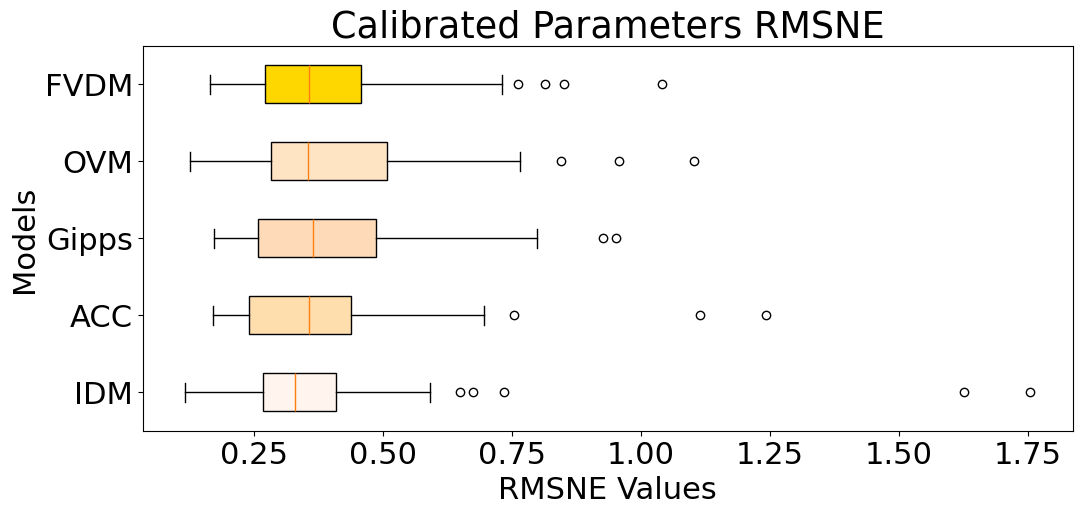

In [85]:
objective = "s_ego_pred_rmsne"
min_vals = [mod.compute_stats(objective)[objective+"_min"] for mod in models]

colors = ['seashell', 'navajowhite', 'peachpuff', 'bisque', 'gold']
labels = model_names[:-1]

fig, ax = plt.subplots(1,1,figsize=(12, 5))
bp = ax.boxplot([arr.detach().cpu().numpy() for arr in min_vals], vert=False, patch_artist=True, tick_labels=labels)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add title and labels
plt.title(f'Calibrated Parameters RMSNE')
plt.xlabel('RMSNE Values')
plt.ylabel('Models')

# Display the plot
plt.savefig("results/cross4poster/s_rmsne_opt_summary.png")
plt.show()

In [86]:
naes = {
    "s":[],
    "v":[],
    "a":[]
}
for mod in models: 
    def_p = mod.hyperparams.from_default(mod.device)
    mod.simulate(def_p, pbar=True)
    naes['s'].append(ParamBaseModelBatch.masked_NAE(mod.s_pred, mod.s, mod.mask))
    naes['v'].append(ParamBaseModelBatch.masked_NAE(mod.v_pred, mod.v, mod.mask))
    naes['a'].append(ParamBaseModelBatch.masked_NAE(mod.a_pred, mod.a, mod.mask))
    
mod = models[0]
s_arr = torch.cat(naes['s'], axis=0)
v_arr = torch.cat(naes['v'], axis=0)
a_arr = torch.cat(naes['a'], axis=0)

# lab_out = label_cells(rmsne_seq, threshold=0.4, slen=mod.seq_lens)

for quant in ['s', 'v', 'a']:
    preds = [getattr(m, quant+"_pred") for m in models]
    preds.append(getattr(mod, quant))
    seqs = torch.cat(preds, axis=0)
    plot_sequences(mod, seqs, "results/cross4poster_def/"+quant, ylab=ylabs[i], prefix="def_"+quant, fsize=(14, 6))
    plot_sequences(mod, seqs, "results/cross4poster_def_color/"+quant, plot_colorblock=True, ylab=ylabs[i], prefix="colored_def_"+quant, fsize=(14, 6))
    

100%|██████████| 6278/6278 [00:01<00:00, 4084.01it/s]


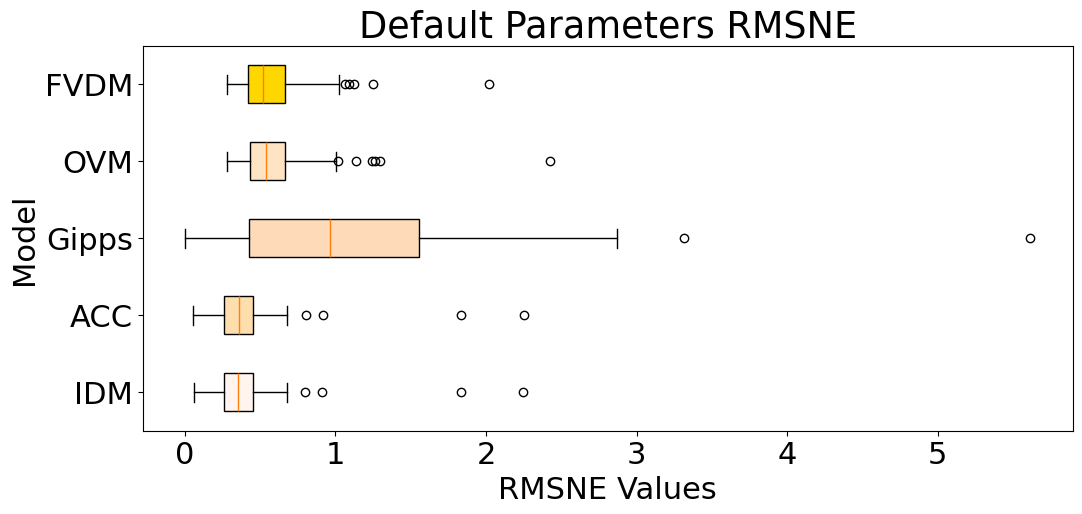

In [87]:
objective = "s_ego_pred_rmsne"
for mod in models:
    mod.simulate(mod.hyperparams.from_default(mod.device))
min_vals = [mod.compute_stats(objective)[objective+"_min"] for mod in models]

colors = ['seashell', 'navajowhite', 'peachpuff', 'bisque', 'gold']
labels = model_names[:-1]

fig, ax = plt.subplots(1,1,figsize=(12,5))
bp = ax.boxplot([arr.detach().cpu().numpy() for arr in min_vals], vert=False, patch_artist=True, tick_labels=labels)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add title and labels
plt.title(f'Default Parameters RMSNE')
plt.xlabel('RMSNE Values')
plt.ylabel('Model')

# Display the plot
plt.savefig("results/cross4poster_def/s_rmsne_def_summary.png")
plt.show()